# **Sleep Quality Analysis**

The **Sleep Health and Lifestyle Dataset** contains 374 rows and 13 columns, providing insights into various factors affecting sleep and daily lifestylehabits. It includes information on **demographics, sleep metrics, lifestyle factors, cardiovascular health, and sleep disorders**. The dataset covers key variables such as age, gender, occupation, sleep duration, quality of sleep, physical activity, stress levels, BMI, blood pressure, heart rate, daily steps, and sleep disorders like insomnia and sleep apnea.

### **Key Features:**

* **Sleep Metrics**: Sleep duration and quality.
* **Lifestyle Factors**: Physical activity levels, stress levels, and BMI categories.
* **Cardiovascular Health**: Blood pressure and heart rate measurements.
* **Sleep Disorders**: Presence of conditions like insomnia and sleep apnea.


## **Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# making differnt directories to save files that we will use in streamlit deployment
os.makedirs("eda_results", exist_ok=True)
os.makedirs("plots", exist_ok=True)
os.makedirs("models", exist_ok=True)

## **Loading & Understanding the Dataset with Pandas**

In [3]:
# Reading Data Head
data = pd.read_excel("sleep_data.xlsx",engine='openpyxl') 
data.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [4]:
# Data Types and Unique Value Counts
data_types = data.dtypes
unique_counts = data.nunique()
data_info = pd.concat([data_types, unique_counts], axis=1)
data_info.columns = ['Data Type', 'Unique Values']
data_info.to_csv("eda_results/data_info.csv")
data_info

,Data Type,Unique Values
Person ID,int64,374
Gender,object,2
Age,int64,31
Occupation,object,11
Sleep Duration,float64,27
Quality of Sleep,int64,6
Physical Activity Level,int64,16
Stress Level,int64,6
BMI Category,object,4
Blood Pressure,object,25


In [5]:
# Generate summary statistics for categorical variables
cat_summary = data.describe(include='O').T
cat_summary.to_csv("eda_results/categorical_summary.csv")  # saving the files for streamlit deployment
cat_summary


,count,unique,top,freq
Gender,374,2,Male,189
Occupation,374,11,Nurse,73
BMI Category,374,4,Normal,195
Blood Pressure,374,25,130/85,99
Sleep Disorder,155,2,Sleep Apnea,78


In [6]:
# Generate summary statistics for numeric variables
num_summary = data.describe().T
num_summary.to_csv("eda_results/numeric_summary.csv") #saving file for streamlit deployment
num_summary

,count,mean,std,min,25%,50%,75%,max
Person ID,374.0,187.500000,108.108742,1.0,94.25,187.5,280.75,374.0
Age,374.0,42.184492,8.673133,27.0,35.25,43.0,50.00,59.0
Sleep Duration,374.0,7.132086,0.795657,5.8,6.40,7.2,7.80,8.5
Quality of Sleep,374.0,7.312834,1.196956,4.0,6.00,7.0,8.00,9.0
Physical Activity Level,374.0,59.171123,20.830804,30.0,45.00,60.0,75.00,90.0
Stress Level,374.0,5.385027,1.774526,3.0,4.00,5.0,7.00,8.0
Heart Rate,374.0,70.165775,4.135676,65.0,68.00,70.0,72.00,86.0
Daily Steps,374.0,6816.844920,1617.915679,3000.0,5600.00,7000.0,8000.00,10000.0


In [7]:
# Outlier Detection (Detailed for all numerical cols)
numeric_cols = ['Person ID', 'Age','Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate','Daily Steps']
outliers = {}
for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[col] = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col].count()
outliers_df = pd.DataFrame.from_dict(outliers, orient='index', columns=['Outlier Count'])
outliers_df.to_csv("eda_results/outliers.csv")
outliers_df 

,Outlier Count
Person ID,0
Age,0
Sleep Duration,0
Quality of Sleep,0
Physical Activity Level,0
Stress Level,0
Heart Rate,15
Daily Steps,0


In [8]:
# 3. Missing Value Analysis
missing_values = data.isnull().sum()
missing_values

Person ID                    0
Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             219
dtype: int64

## **Data Wrangling**

In [9]:
# In Sleep Disorder column, 219 Nan are present, 
# we cannot drop it since there are only 374 rows. We will replace it by "No Disease".
valid_categories = ["No Disease", "Insomnia", "Sleep Apnea"]
data["Sleep Disorder"] = data["Sleep Disorder"].apply(
    lambda x: x if x in valid_categories else "No Disease"
)
data.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,No Disease
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,No Disease
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,No Disease
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [10]:
# Check null values again
data.isna().sum()

Person ID                  0
Gender                     0
Age                        0
Occupation                 0
Sleep Duration             0
Quality of Sleep           0
Physical Activity Level    0
Stress Level               0
BMI Category               0
Blood Pressure             0
Heart Rate                 0
Daily Steps                0
Sleep Disorder             0
dtype: int64

In [11]:
# In the BMI Category column there are labels like Normal, Normal Weight, Overweight, and Obese.
# There is a possibility that the data was collected from multiple sources, leading to inconsistent labeling
# To ensure consistent labeling we'll map Normal Weight to Normal
data["BMI Category"] = data["BMI Category"].replace({"Normal Weight": "Normal"})

## **Exploratory data analysis (EDA)**

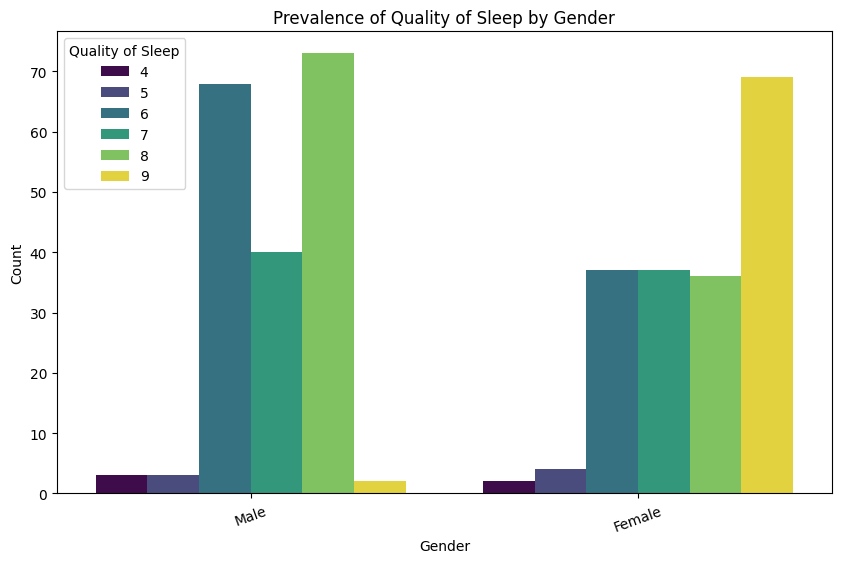

In [12]:
# 1) Gender vs Quality of Sleep (Bar Chart with Hue)
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', hue='Quality of Sleep', data=data, palette="viridis")
plt.xticks(rotation=20)
plt.title('Prevalence of Quality of Sleep by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Quality of Sleep')
plt.show()
plt.savefig("plots/gender_vs_quality_sleep.png")
plt.close()

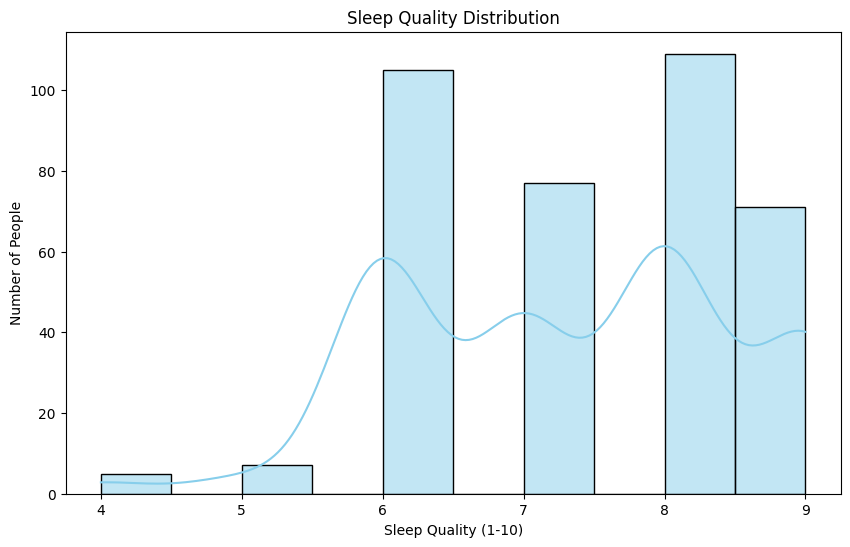

In [13]:
# 2) Sleep Quality Distribution (Histogram)
plt.figure(figsize=(10, 6))
sns.histplot(data['Quality of Sleep'], bins=10, kde=True, color='skyblue')
plt.title('Sleep Quality Distribution')
plt.xlabel('Sleep Quality (1-10)')
plt.ylabel('Number of People')
plt.show()
plt.savefig("plots/sleep_quality_distribution.png")
plt.close()

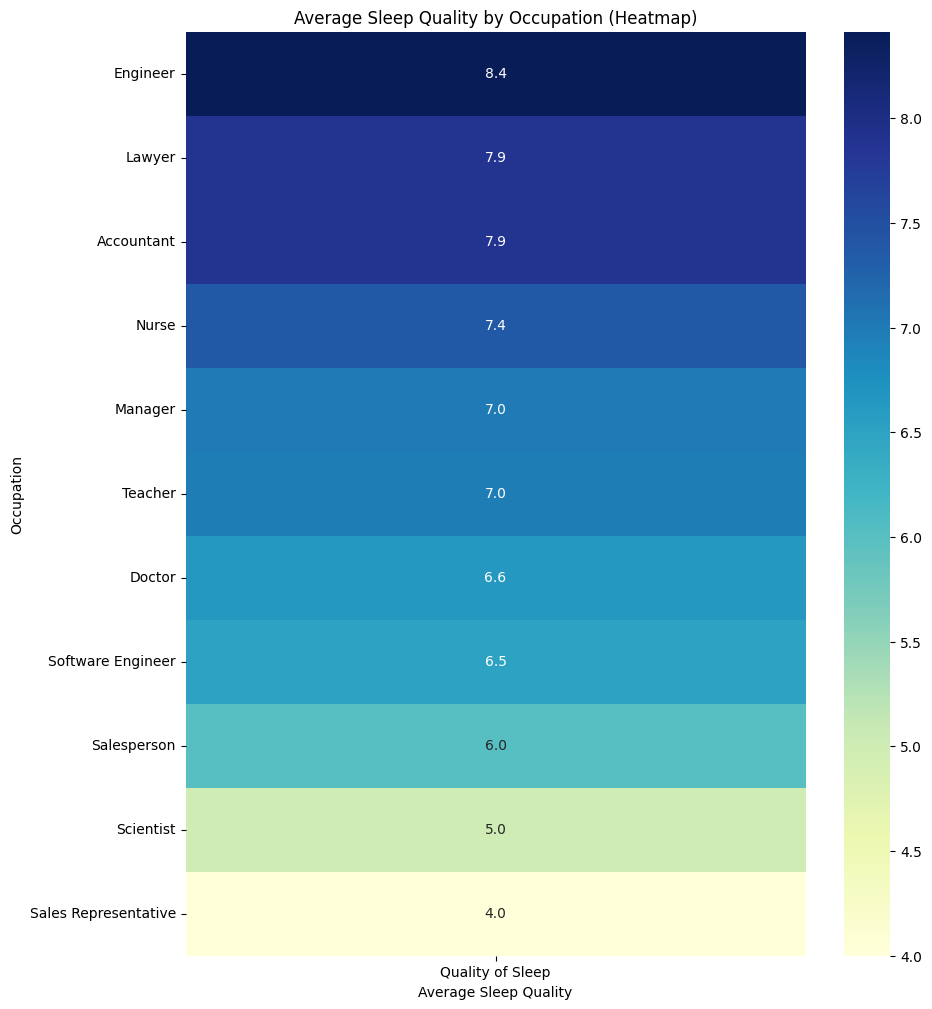

In [14]:
# 3) Average Sleep Quality by Occupation (Heatmap)
plt.figure(figsize=(10, 12))
heatmap_data = data.groupby('Occupation')['Quality of Sleep'].mean().sort_values(ascending=False)
sns.heatmap(heatmap_data.to_frame(), annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Average Sleep Quality by Occupation (Heatmap)')
plt.xlabel('Average Sleep Quality')
plt.ylabel('Occupation')
plt.show()
plt.savefig("plots/sleep_quality_by_occupation_heatmap.png")
plt.close()

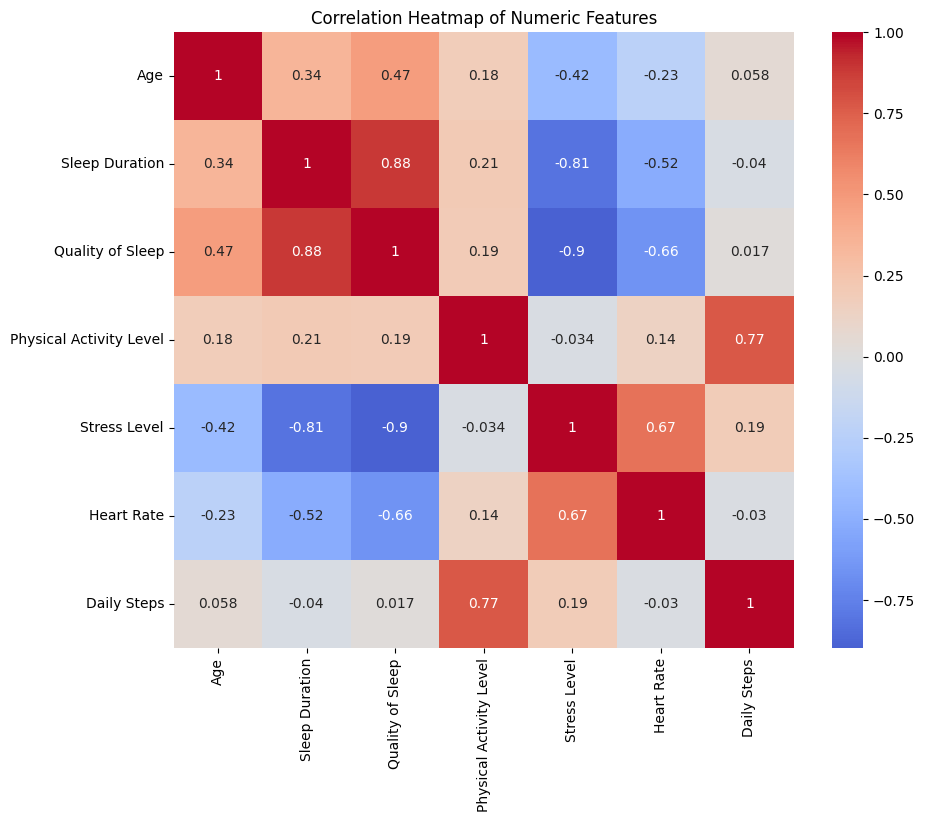

In [15]:
# 4) Correlation Heatmap for Numeric Columns
numeric_cols = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 
                'Stress Level', 'Heart Rate', 'Daily Steps']
corr = data[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()
plt.savefig("plots/correlation_heatmap.png")
plt.close()


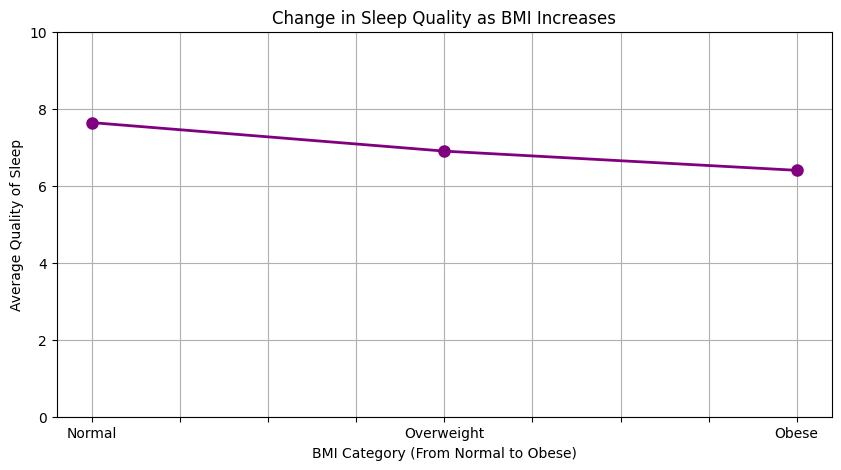

In [16]:
# 5) Sleep Quality by BMI Category (Line Chart)
bmi_order = ['Normal', 'Overweight', 'Obese']
bmi_sleep = data.groupby('BMI Category')['Quality of Sleep'].mean().reindex(bmi_order)
plt.figure(figsize=(10, 5))
bmi_sleep.plot(kind='line', marker='o', color='purple', linewidth=2, markersize=8)
plt.title('Change in Sleep Quality as BMI Increases')
plt.xlabel('BMI Category (From Normal to Obese)')
plt.ylabel('Average Quality of Sleep')
plt.ylim(0, 10)
plt.grid()
plt.show()
plt.savefig("plots/sleep_quality_by_bmi.png")
plt.close()

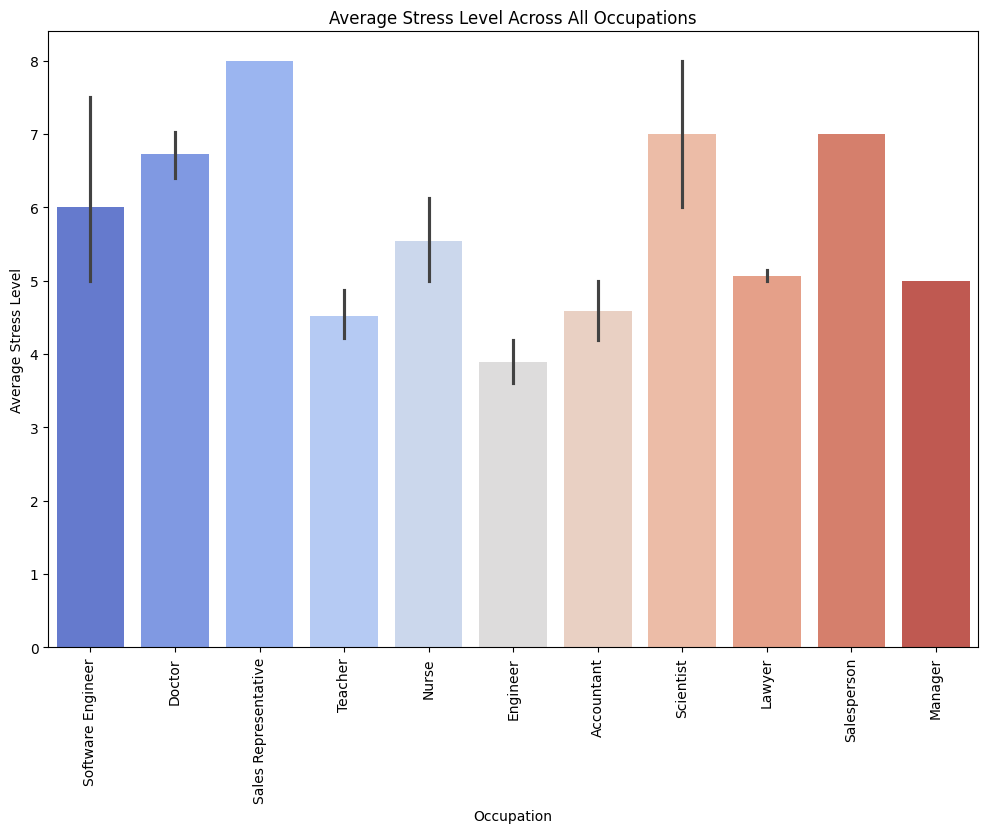

In [17]:
# 6) Stress Level by Occupation (Bar Chart with Hue for all occupations)
plt.figure(figsize=(12, 8))
sns.barplot(data=data, x="Occupation", y="Stress Level", hue="Occupation", palette="coolwarm", legend=False)
plt.title("Average Stress Level Across All Occupations")
plt.xlabel("Occupation")
plt.ylabel("Average Stress Level")
plt.xticks(rotation=90)
plt.show()
plt.savefig("plots/stress_level_by_occupation.png")
plt.close()

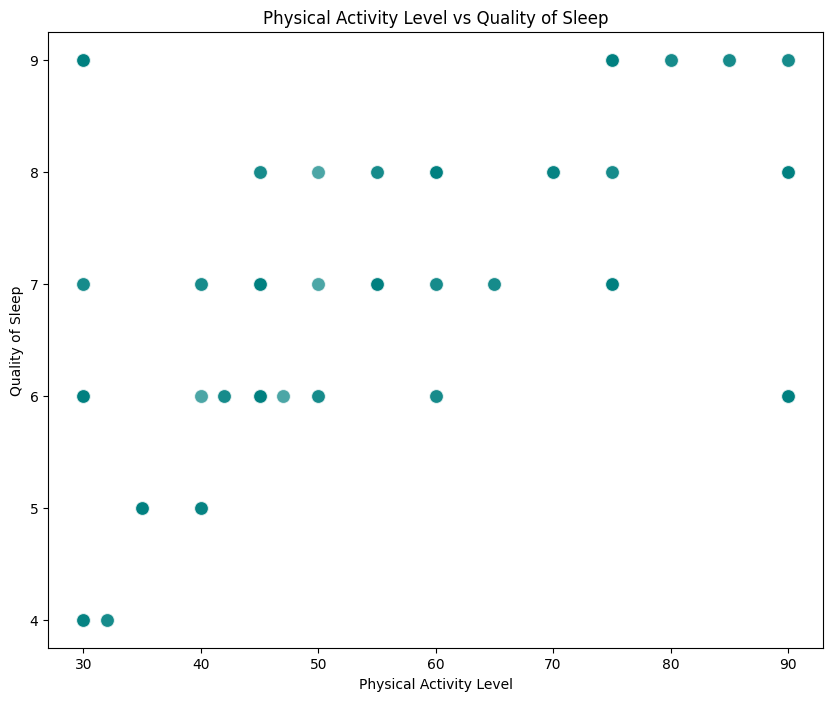

In [18]:
# 7) Physical Activity Level vs Quality of Sleep (Scatter Plot)
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x="Physical Activity Level", y="Quality of Sleep", s=100, alpha=0.7, color='teal')
plt.title("Physical Activity Level vs Quality of Sleep")
plt.xlabel("Physical Activity Level")
plt.ylabel("Quality of Sleep")
plt.show()
plt.savefig("plots/activity_vs_quality_sleep.png")
plt.close()

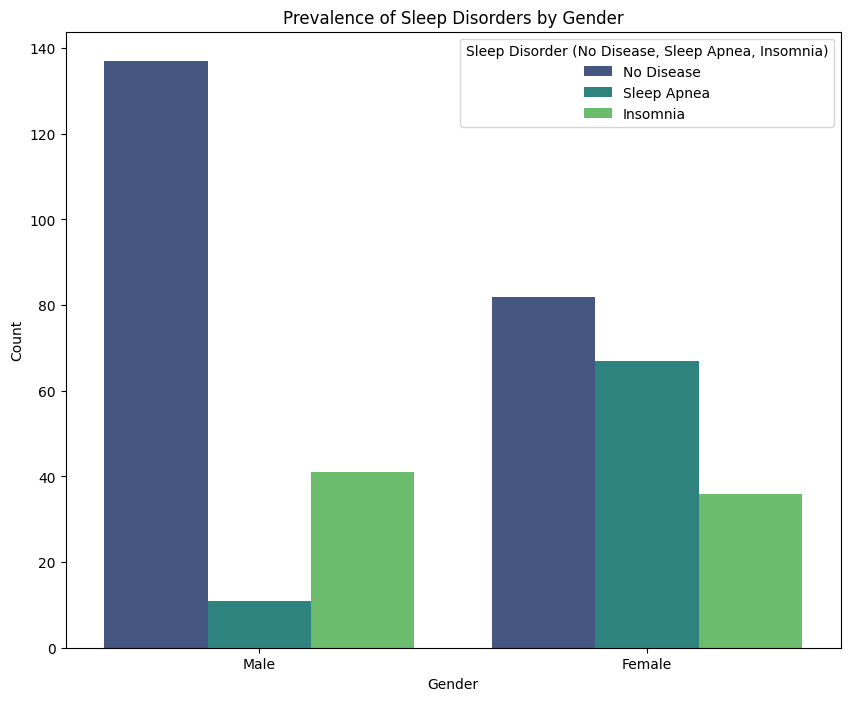

In [19]:
# 8) Prevalence of Sleep Disorders by Gender (Bar Chart with Hue)
plt.figure(figsize=(10, 8))
sns.countplot(data=data, x="Gender", hue="Sleep Disorder", palette="viridis")
plt.title("Prevalence of Sleep Disorders by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Sleep Disorder (No Disease, Sleep Apnea, Insomnia)")
plt.show()
plt.savefig("plots/sleep_disorder_by_gender.png")
plt.close()

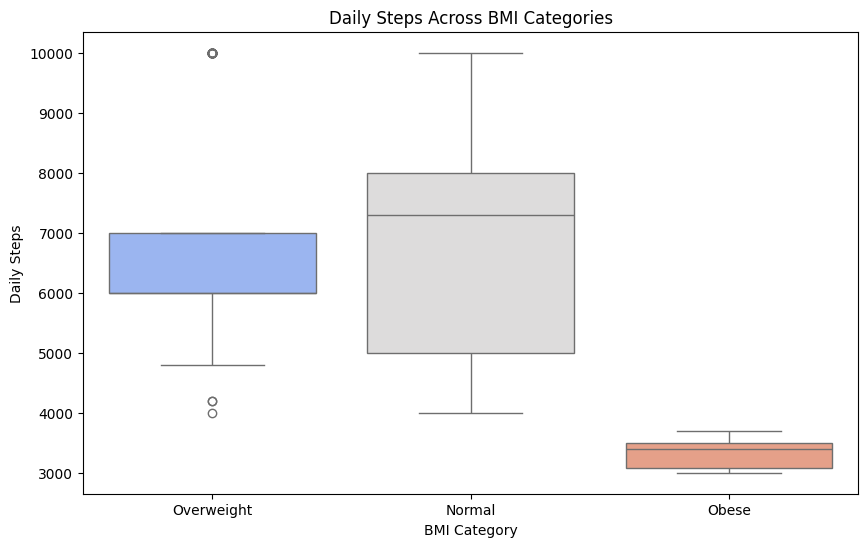

In [20]:
# 9) Daily Steps Across BMI Categories (Box Plot with Hue)
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x="BMI Category", y="Daily Steps", hue="BMI Category", palette="coolwarm", legend=False)
plt.title("Daily Steps Across BMI Categories")
plt.xlabel("BMI Category")
plt.ylabel("Daily Steps")
plt.show()
plt.savefig("plots/daily_steps_by_bmi.png")
plt.close()

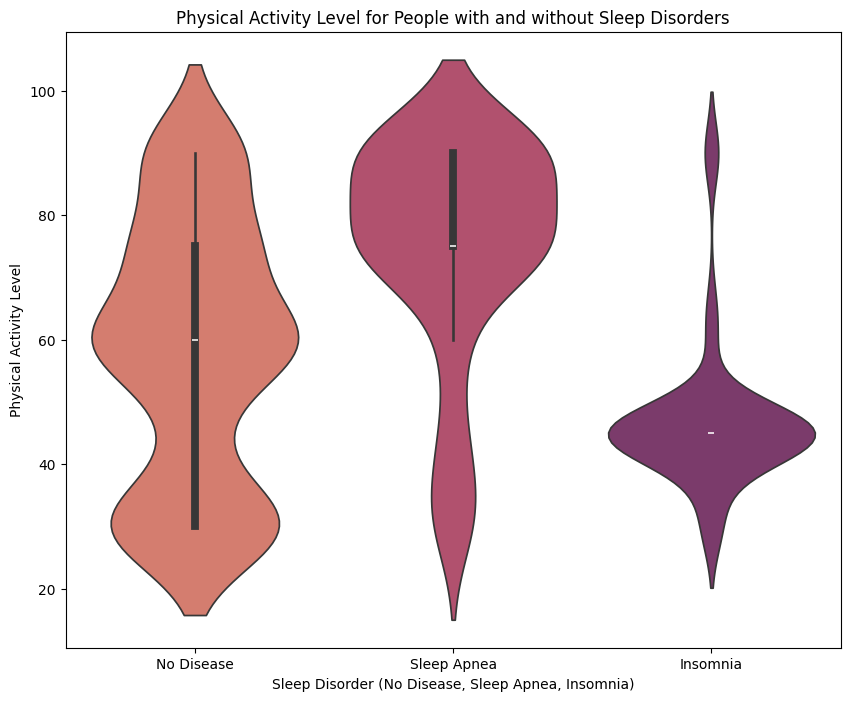

In [21]:
# 10) Physical Activity Level by Sleep Disorder (Violin Plot with Hue)
plt.figure(figsize=(10, 8))
sns.violinplot(data=data, x="Sleep Disorder", y="Physical Activity Level", hue="Sleep Disorder", palette="flare", legend=False)
plt.title("Physical Activity Level for People with and without Sleep Disorders")
plt.xlabel("Sleep Disorder (No Disease, Sleep Apnea, Insomnia)")
plt.ylabel("Physical Activity Level")
plt.show()
plt.savefig("plots/activity_by_sleep_disorder.png")
plt.close()

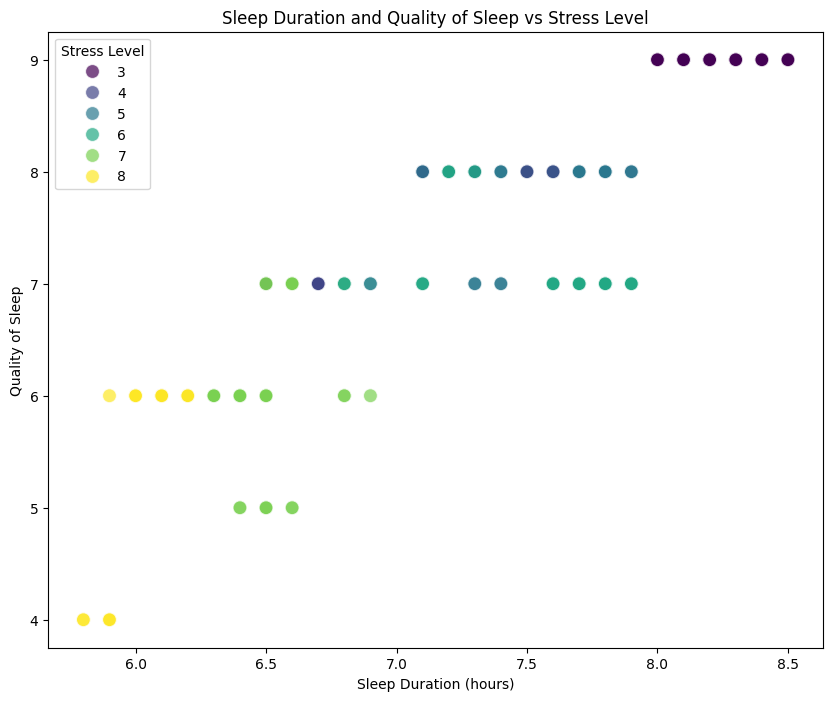

In [22]:
# 11) Sleep Duration and Quality vs Stress Level (Scatter with Hue)
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x="Sleep Duration", y="Quality of Sleep", hue="Stress Level", palette="viridis", s=100, alpha=0.7)
plt.title("Sleep Duration and Quality of Sleep vs Stress Level")
plt.xlabel("Sleep Duration (hours)")
plt.ylabel("Quality of Sleep")
plt.legend(title="Stress Level")
plt.show()
plt.savefig("plots/sleep_vs_stress.png")
plt.close()

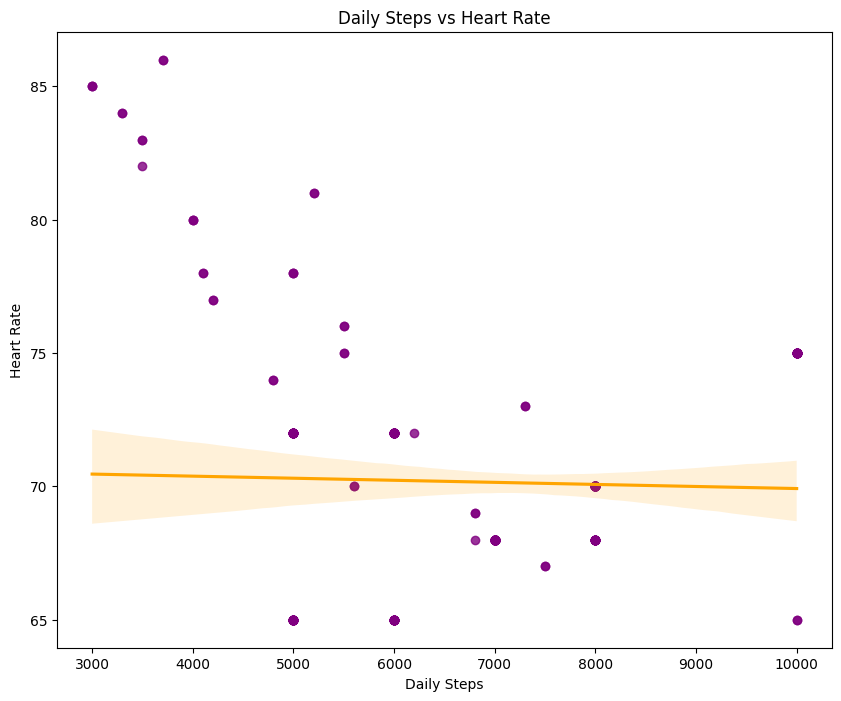

In [23]:
# 12) Daily Steps vs Heart Rate (Regression Plot)
plt.figure(figsize=(10, 8))
sns.regplot(data=data, x="Daily Steps", y="Heart Rate", scatter_kws={"color": "purple"}, line_kws={"color": "orange"})
plt.title("Daily Steps vs Heart Rate")
plt.xlabel("Daily Steps")
plt.ylabel("Heart Rate")
plt.show()
plt.savefig("plots/steps_vs_heart_rate.png")
plt.close()

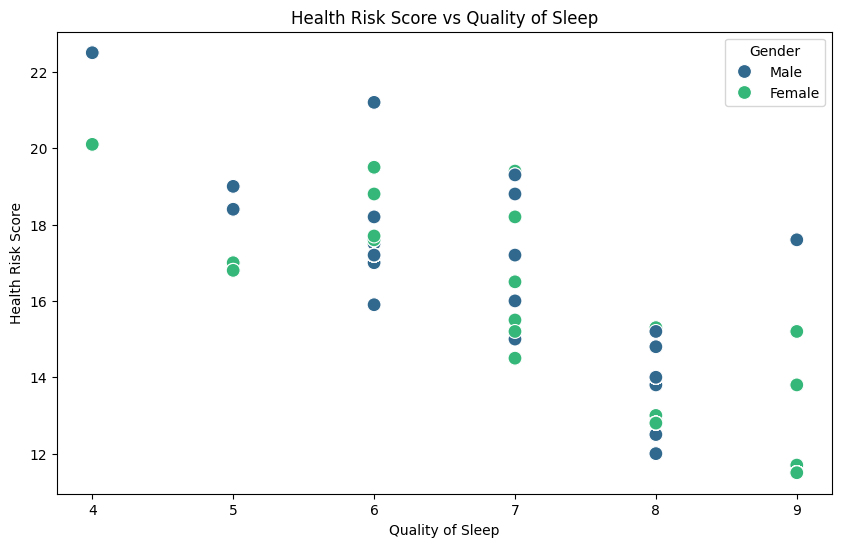

In [24]:
# 13) Health Risk Score vs Quality of Sleep (Scatter with Hue)
bmi_mapping = {'Normal': 1, 'Overweight': 2, 'Obese': 3}
data['BMI Score'] = data['BMI Category'].map(bmi_mapping)
data['Health Risk Score'] = (data['BMI Score'] * 2) + data['Stress Level'] + (data['Heart Rate'] / 10)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Quality of Sleep', y='Health Risk Score', hue='Gender', palette='viridis', s=100)
plt.title('Health Risk Score vs Quality of Sleep')
plt.xlabel('Quality of Sleep')
plt.ylabel('Health Risk Score')
plt.legend(title='Gender')
plt.show()
plt.savefig("plots/health_risk_vs_quality.png")
plt.close()

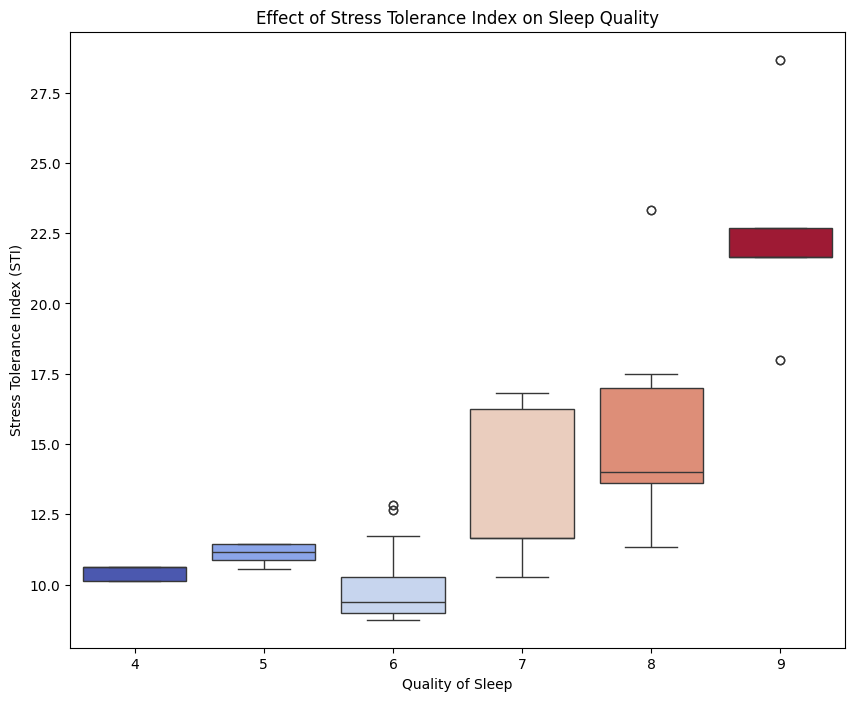

In [25]:
# 14) Stress Tolerance Index vs Quality of Sleep (Box Plot with Hue)
data['STI'] = data['Heart Rate'] / data['Stress Level'].replace(0, np.nan)
plt.figure(figsize=(10, 8))
sns.boxplot(data=data, x='Quality of Sleep', y='STI', hue='Quality of Sleep', palette='coolwarm', legend=False)
plt.title('Effect of Stress Tolerance Index on Sleep Quality')
plt.xlabel('Quality of Sleep')
plt.ylabel('Stress Tolerance Index (STI)')
plt.show()
plt.savefig("plots/sti_vs_quality_sleep.png")
plt.close()

## **Data Preprocessing**

In [26]:
# Splitting the Blood Pressure column into Systolic and Diastolic values, then drop the original column.
data[["Systolic", "Diastolic"]] = data["Blood Pressure"].str.split("/", expand=True).astype(float)
data.drop("Blood Pressure", axis=1, inplace=True)

In [27]:
data.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,BMI Score,Health Risk Score,STI,Systolic,Diastolic
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,No Disease,2,17.7,12.833333,126.0,83.0
1,2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,No Disease,1,17.5,9.375000,125.0,80.0
2,3,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,No Disease,1,17.5,9.375000,125.0,80.0
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,3,22.5,10.625000,140.0,90.0
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,3,22.5,10.625000,140.0,90.0


In [28]:
# Separate features and target variable
X = data.drop(columns=["Sleep Disorder", "Person ID"])
y = data["Sleep Disorder"]

In [29]:
# Encode target variable
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y

array([1, 1, 1, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,

In [30]:
# Scale numerical features
scaler = StandardScaler()
num = X.select_dtypes(exclude=["object"]).columns.tolist()
X[num] = scaler.fit_transform(X[num])
X.head()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,BMI Score,Health Risk Score,STI,Systolic,Diastolic
0,Male,-1.753096,Software Engineer,-1.298887,-1.098280,-0.825418,0.347021,Overweight,1.654719,-1.619584,1.004126,0.938881,-0.353306,-0.330002,-0.268102
1,Male,-1.637643,Doctor,-1.173036,-1.098280,0.039844,1.475592,Normal,1.170474,1.970077,-0.818899,0.860641,-1.101280,-0.459239,-0.755640
2,Male,-1.637643,Doctor,-1.173036,-1.098280,0.039844,1.475592,Normal,1.170474,1.970077,-0.818899,0.860641,-1.101280,-0.459239,-0.755640
3,Male,-1.637643,Sales Representative,-1.550588,-2.771424,-1.402260,1.475592,Obese,3.591698,-2.362273,2.827150,2.816644,-0.830928,1.479309,0.869486
4,Male,-1.637643,Sales Representative,-1.550588,-2.771424,-1.402260,1.475592,Obese,3.591698,-2.362273,2.827150,2.816644,-0.830928,1.479309,0.869486


In [31]:
# One-hot encode categorical features
cat_feat = X.select_dtypes(include=["object"]).columns.tolist()
X = pd.get_dummies(X, columns=cat_feat)
X.head()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,BMI Score,Health Risk Score,STI,...,Occupation_Manager,Occupation_Nurse,Occupation_Sales Representative,Occupation_Salesperson,Occupation_Scientist,Occupation_Software Engineer,Occupation_Teacher,BMI Category_Normal,BMI Category_Obese,BMI Category_Overweight
0,-1.753096,-1.298887,-1.098280,-0.825418,0.347021,1.654719,-1.619584,1.004126,0.938881,-0.353306,...,False,False,False,False,False,True,False,False,False,True
1,-1.637643,-1.173036,-1.098280,0.039844,1.475592,1.170474,1.970077,-0.818899,0.860641,-1.101280,...,False,False,False,False,False,False,False,True,False,False
2,-1.637643,-1.173036,-1.098280,0.039844,1.475592,1.170474,1.970077,-0.818899,0.860641,-1.101280,...,False,False,False,False,False,False,False,True,False,False
3,-1.637643,-1.550588,-2.771424,-1.402260,1.475592,3.591698,-2.362273,2.827150,2.816644,-0.830928,...,False,False,True,False,False,False,False,False,True,False
4,-1.637643,-1.550588,-2.771424,-1.402260,1.475592,3.591698,-2.362273,2.827150,2.816644,-0.830928,...,False,False,True,False,False,False,False,False,True,False


In [32]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Modeling with Random Forest**

In [33]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(x_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [34]:
y_pred_rf = rf_model.predict(x_test)

## **ModelEvaluation**

In [35]:
# Model Accuracy
accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy: {accuracy*100:.4f}%')

Accuracy: 88.0000%


In [36]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
print('Confusion Matrix:')
conf_matrix

Confusion Matrix:


array([[13,  1,  2],
       [ 1, 42,  0],
       [ 4,  1, 11]], dtype=int64)

In [37]:
# Classification Report
class_report = classification_report(y_test, y_pred_rf)
print('Classification Report:')
class_report

Classification Report:


'              precision    recall  f1-score   support\n\n           0       0.72      0.81      0.76        16\n           1       0.95      0.98      0.97        43\n           2       0.85      0.69      0.76        16\n\n    accuracy                           0.88        75\n   macro avg       0.84      0.83      0.83        75\nweighted avg       0.88      0.88      0.88        75\n'

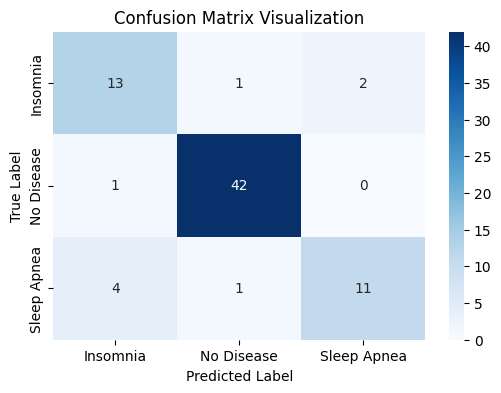

In [38]:
# Visualize and save confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Visualization")
plt.savefig("models/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

In [39]:
# Save model and preprocessors in models folder
with open("models/rf_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)
with open("models/label_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)
with open("models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open("models/training_columns.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)


In [40]:
# Save accuracy and classification report
with open("models/accuracy.txt", "w") as f:
    f.write(f"{accuracy*100:.4f}")
with open("models/classification_report.txt", "w") as f:
    f.write(class_report)

### **Additional EDA**

In [41]:
# Q: How does Sleep Duration and Sleep Quality vary across different age groups?
age_bins = [18, 30, 40, 50, 60]
age_labels = ['18-30', '31-40', '41-50', '51-60']
data['Age Group'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels, right=False)
avg_sleep = data.groupby('Age Group', observed=True)[['Sleep Duration', 'Quality of Sleep']].mean().round(2)
avg_sleep.to_csv("eda_results/age_group_sleep.csv")
avg_sleep

,Sleep Duration,Quality of Sleep
Age Group,,
18-30,6.47,5.79
31-40,7.07,7.23
41-50,6.91,6.97
51-60,7.63,8.17


In [42]:
# Q: How do Blood Pressure, Heart Rate, and Daily Steps vary across different levels of Sleep Quality?
#data['Systolic BP'] = data['Blood Pressure'].str.split('/').str[0].astype(float)
table = data.groupby('Quality of Sleep')[['Systolic', 'Heart Rate', 'Daily Steps']].mean()
table.to_csv("eda_results/sleep_quality_metrics.csv")
table

,Systolic,Heart Rate,Daily Steps
Quality of Sleep,,,
4,136.400000,83.400000,3880.000000
5,130.571429,77.714286,4257.142857
6,131.047619,73.209524,7092.380952
7,127.701299,69.415584,6659.740260
8,124.091743,68.633028,7462.385321
9,131.887324,67.154930,6047.887324


In [43]:
# Feature Distribution Analysis
distribution_stats = data[numeric_cols].agg(['skew', 'kurtosis']).T
distribution_stats.to_csv("eda_results/distribution_stats.csv")
distribution_stats

,skew,kurtosis
Age,0.257222,-0.909780
Sleep Duration,0.037554,-1.286506
Quality of Sleep,-0.207448,-0.748276
Physical Activity Level,0.074487,-1.266068
Stress Level,0.154330,-1.327307
Heart Rate,1.224824,2.286455
Daily Steps,0.178277,-0.394031


In [44]:
# Grouped Aggregations
grouped_stats = data.groupby("Sleep Disorder")[numeric_cols].mean()
grouped_stats.to_csv("eda_results/grouped_stats.csv")
grouped_stats

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
Sleep Disorder,,,,,,,
Insomnia,43.519481,6.589610,6.532468,46.818182,5.870130,70.467532,5901.298701
No Disease,39.036530,7.358447,7.625571,57.949772,5.114155,69.018265,6852.968037
Sleep Apnea,49.705128,7.032051,7.205128,74.794872,5.666667,73.089744,7619.230769
